In [1]:
import numpy as np
import pandas as pd
import re
from scipy.spatial.distance import cdist
from google.colab import drive
from nltk.stem import WordNetLemmatizer
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
data_file = "/content/drive/MyDrive/capstone-pimco/Part1/data/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We precollected a list of directional word for each topic.

For one sentence， suppose we detect m potential directional words $S$, which are similar to the direction word we found, and n feature words $F$, which contribute the most to its topic classification result. 

$$S = [s_1,s_2,...s_m]$$
$$ DW = [dw_1,dw_2,...,dw_m]$$
$$ Sim = [sim_1,sim_2,...,sim_m]$$
$$F = [f_1,f_2,...f_n]$$
$$C = [c_,c_2,...c_n]$$

For $s_i$ in $S$, $dw_i$ is the precollected directional word for this potential directional word. And $sim_i$ is the similarity of these two words. When one potential directional word has more than one similar precollected directional word, we choose the one with the highest similarity.

For $f_i$ in $F$, $c_i$ is its contribution to the classification result, provided by tree interpretor.

First, we found the position of the words in the sentence.

For potential directional words: $Idx = [Idx_{s_1} , Idx_{s_2}, ...,Idx_{s_m}]$

For features: $P = [ [p_1,p_2,...]_{f_1},[p_1,p_2,...]_{f_2},....]$
Here, one potential directional words only has one dix, but one feature may has multple postions. Because when we produce potential directional words we used its index to identify it, but when it comes to the features it is different.

Then for each potential directional words we find an occurence of feature, which is the closest to this word.

$$Pair(S,P) = [(s_1, p_{i_1,f_{j_1},s_1}),(s_2, p_{i_2,f_{j_2},s_2}),...,(s_m, p_{i_m,f_{j_m},s_m})]$$

Then we calculate the final direction index as following:

$$ Dir\_index = \frac{1}{\sum c}*(sim_1*Dir(dw_1)*c_{j_1}+ sim_2*Dir(dw_2)*c_{j_2}+...+sim_m*Dir(dw_m)*c_{j_m}) $$

$Dir(dw_i)$ refers to the direction label of the precollected direction word, it is a integer in ${0,-1,1}$.

Then for each sentence we get a direction index indicating its direction. And base on the index we set a reasonable threshold to decide whether its direction is 0,-1 or 1.

## Import data

In [31]:
topics = ['credit', 'fed_funds_rate',
       'financial_markets', 'geopolitical_uncertainty',
       'growth', 'housing', 'inflation', 'labor_market',
       'liquidity_measures', 'quantitative_easing']

**Data: manually created dictionary**

In [5]:
direction_dict = pd.read_csv(data_file+"directionality_dictionary_all_df.csv")
direction_dict['direction'] = direction_dict['direction'].astype('int')
direction_dict

,Unnamed: 0,word,direction
0,0,healthy,1
1,1,unhealthy,-1
2,2,strengthen,1
3,3,weaken,-1
4,4,boost,1
...,...,...,...
148,148,looseness,-1
149,149,broader,1
150,150,advance,1
151,151,recede,-1


The data is the information we gain by using tree interpretate

In [68]:
'''
Getting the data
@threshold: the threshold for determine whether a word is similar with one of the direction words from out dictionary
make sure you have the file already in the data file before accessing it
'''

topic_dfs = {}
threshold = 0.6 
for topic in topics:
  topic_dfs[topic] = pd.read_csv(data_file+'direction_words_train' +str(threshold)+'/directionwords_'+ topic + '.csv', index_col=0)
  topic_df = topic_dfs[topic] 
  topic_df['true_topic'] = topic_df['true_topic'].astype('str')
  topic_df = topic_df[(topic_df['true_topic'].str.contains(topic)) | (topic_df['true_topic']=='nan')]
  topic_df['direction'] = topic_df['direction'].astype('float')
  topic_df = topic_df[~topic_df['direction'].isna()]
  topic_df['direction'] = topic_df['direction'].astype('int')
  topic_dfs[topic] = topic_df
  topic_dfs[topic]['feature_contribution'] = pd.read_csv(data_file+'feature_contribution_train/'+ topic + '.csv', index_col=0)['feature_contribution'] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Compute the feature_contribution index (2 gram using the middle position)

As what we have done before, we get the grams which contributed the most to the topic assignment of the sentence. Here we get the position of these feature in the sentence for later use.

In [10]:
import math

In [11]:
lem = WordNetLemmatizer()
def position_topic_words(row):
    text = re.findall(r'(?u)\b\w\w+\b', row['cleaned_text'])
    text = [lem.lemmatize(word.lower()) for word in text]
    position_dict = {}
    for word, _ in eval(row['feature_contribution']):
        if len(word.split()) > 1:
            if word in ' '.join(text):
              for index in np.where(np.array(text) == word.split()[0])[0] :
                position_dict[index+(len(word.split())-1)/2] = word
        else:
            if word in text:
                for index in np.where(np.array(text) == word)[0] :
                  position_dict[index] = word
    return position_dict

In [30]:
row={}
row['cleaned_text'] = "i will make the case for further housing related policy intervention that would help stabilize home price, improve the housing outlook and generate an earlier recovery in housing activity"
row['feature_contribution'] = "[('housing', 0.32745680308683756)]"
position_topic_words(row)

{6: 'housing', 18: 'housing', 26: 'housing'}

In [13]:
text = re.findall(r'(?u)\b\w\w+\b', row['cleaned_text'])
text = [lem.lemmatize(word.lower()) for word in text]

In [14]:
indexes = np.where(np.array(text) == 'housing')[0]
indexes

array([ 6, 18, 26])

### From feature words pair(feature with the closest direction words) - absolute position distance



In [40]:
import sys
'''

'''
def find_the_closest_direction_absolute(feature_index, similar_index,position_dict,similar_words):
    pair_dict = {}
    for fea_idx in feature_index:
      distances = []
      for idx in range(len(similar_index)):
        dir_idx = similar_index[idx]
        if lem.lemmatize(similar_words[idx]) != lem.lemmatize(position_dict[fea_idx]): # ignore cases when direction word is stem of feature word
          distances.append(np.abs(dir_idx-fea_idx))
        else:
          distances.append(sys.maxsize)
      pair_dict[fea_idx] = (np.argmin(distances), np.min(distances))
    return pair_dict

### From feature words pair(feature with the closest direction words) - dependency parse tree distance




In [16]:
import spacy
import networkx as nx
nlp = spacy.load('en_core_web_sm')

In [47]:
text = nlp("many community bank cannot afford the investment in abl infrastructure and specialized lending personnel")

In [48]:
for token in text:
  print((token.head.text,token.text,token.dep_))

('bank', 'many', 'amod')
('bank', 'community', 'compound')
('afford', 'bank', 'nsubj')
('afford', 'can', 'aux')
('afford', 'not', 'neg')
('afford', 'afford', 'ROOT')
('investment', 'the', 'det')
('afford', 'investment', 'dobj')
('investment', 'in', 'prep')
('infrastructure', 'abl', 'compound')
('in', 'infrastructure', 'pobj')
('infrastructure', 'and', 'cc')
('personnel', 'specialized', 'amod')
('personnel', 'lending', 'compound')
('infrastructure', 'personnel', 'conj')


In [49]:
spacy.displacy.render(text, style='dep', jupyter=True, options={'distance': 90})

In [53]:
edges = []
for token in text:
  for child in token.children:
    edges.append(('{0}'.format(token.lower_.strip()),'{0}'.format(child.lower_.strip())))

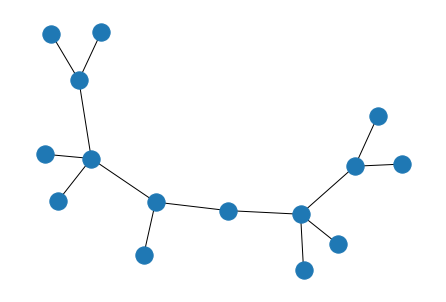

In [51]:
graph = nx.Graph(edges)
nx.draw(graph)

In [58]:
edges

[('bank', 'many'),
 ('bank', 'community'),
 ('afford', 'bank'),
 ('afford', 'can'),
 ('afford', 'not'),
 ('afford', 'investment'),
 ('investment', 'the'),
 ('investment', 'in'),
 ('in', 'infrastructure'),
 ('infrastructure', 'abl'),
 ('infrastructure', 'and'),
 ('infrastructure', 'personnel'),
 ('personnel', 'specialized'),
 ('personnel', 'lending')]

In [56]:
 nx.has_path(graph,'lending','investment')

True

In [57]:
nx.shortest_path_length(graph,source='lending',target ='investment')

4

In [70]:
from nltk.corpus.reader import sentiwordnet
def find_the_closest_direction_spacy(sentence,dir_words,fea_words,feature_index):
    text = nlp(sentence)
    edges = []
    for token in text:
      for child in token.children:
        edges.append(('{0}'.format(token.lower_.strip()),'{0}'.format(child.lower_.strip())))
    graph = nx.Graph(edges)
    pair_dict = {}
    for i in range(len(feature_index)):
      fea_idx = feature_index[i]
      distances = []
      for idx in range(len(dir_words)):
        if lem.lemmatize(fea_words[i]) != lem.lemmatize(dir_words[idx]): # ignore cases when direction word is stem of feature word
          if len(fea_words[i])>1:
            fea_words[i] = fea_words[i].split()[-1]
          if graph.has_node(fea_words[i]) and graph.has_node(dir_words[idx]) and nx.has_path(graph,fea_words[i],dir_words[idx]):
            distances.append(nx.shortest_path_length(graph,source=fea_words[i],target = dir_words[idx]))          
          else:
            distances.append(sys.maxsize)
        else:
          distances.append(sys.maxsize)
      pair_dict[fea_idx] = (np.argmin(distances), np.min(distances))
    return pair_dict

In [104]:
def compute_score(close_dict, feature_dict, sentence_dict, negative_list, direction_list, similarity_list,aggregate_method='distance', score_type='stem'):
  if score_type == 'stem':
    contribution = []
    direct = []
    inv_distances = []
    for i, fea_idx in enumerate(close_dict.keys()):
        idx, distance = close_dict[fea_idx]
        if distance == 0: # ignore cases when topic word and directionality word is the same
            continue
        direct.append(negative_list[idx]*direction_list[idx])
        inv_distances.append(1/distance)
        contribution.append(feature_dict[sentence_dict[fea_idx]])
  if score_type == 'similarity':
    """
    close_dict:  {feature index:(simialr_word_index in the orignal list, distance)}
    feature_dict:  {feature words : contribution}
    sentence_dict: {feature index : feature word}
    negative_list : [-1 or 1]
    direction_list : [-1,0,1]
    similarity_list : [similarity]
    """
    contribution = []
    direct = []
    inv_distances = []
    for i, dict_index in enumerate(close_dict.keys()):
      simindex_in_list, distance = close_dict[dict_index]
      feature_index = dict_index
      if distance == 0:
        continue
      direct.append(negative_list[simindex_in_list] * direction_list[simindex_in_list]* similarity_list[simindex_in_list])
      inv_distances.append(1/distance)
      contribution.append(feature_dict[sentence_dict[feature_index]])
  if len(direct) == 0:
    return 0
  if aggregate_method == 'simple':
    res = np.mean(np.array(direct))
  elif aggregate_method == 'distance':
      weightd = np.array(inv_distances)/len(inv_distances)
      res = np.sum(weightd*np.array(direct))
  elif aggregate_method == 'contribution':
      weightc = np.array(np.abs(contribution))/np.sum(np.abs(contribution))
      res = np.sum(weightc*np.array(direct))
  elif aggregate_method == 'distance_contribution':
      weightc = np.array(np.abs(contribution))/np.sum(np.abs(contribution))
      weightd = np.array(inv_distances)/len(inv_distances)
      res = np.sum(weightc*weightd*np.array(direct))
  else:
      raise Exception("Invalid method!")
  return res

In [65]:
aggregate_method = 'distance'
for topic in topics:
  df = topic_dfs[topic]
  pred_distance_spacy = []
  for index, row_1 in df.iterrows():
     ## find the position
    sentence = row_1['cleaned_text']
    features = eval(row_1['feature_contribution'])
    negative_list = [-2*i+1 for i in eval(row_1['negative_words'])]
    if len(negative_list) == 0:
      pred_distance_spacy.append(0)
      continue
    direction_list = eval(row_1['directionalities'])
    similar_words = eval(row_1['similar_words'])
    feature_dict = {}
    for item in features:
      feature_dict[item[0]] = item[1]
    for words in feature_dict.keys():
      sentence_dict = position_topic_words(row_1)

    ## find the close 
    feature_index = list(sentence_dict.keys())
    similar_index = eval(row_1['similar_idx'])
    if len(feature_index) == 0:
        pred_distance_spacy.append(0)
    else:
        close_dict_spacy = find_the_closest_direction_spacy(sentence, similar_words, list(sentence_dict.values()), feature_index)
        
        # find the direction 
        score = compute_score(close_dict_spacy, feature_dict, sentence_dict, negative_list, direction_list, method=aggregate_method)
        pred_distance_spacy.append(score)
  df['pred_distance_spacy_fbp'] = pred_distance_spacy

### Combine all parts

In [107]:
def get_directionality_prediction(data,distance_type,score_type,aggregate_method):
  pred = []
  for index, row_1 in data.iterrows():
    ## find the position
    sentence = row_1['cleaned_text']
    features = eval(row_1['feature_contribution'])
    negative_list = [-2*i+1 for i in eval(row_1['negative_words'])]
    if len(negative_list) == 0:
      pred.append(0)
      continue
    direction_list = eval(row_1['directionalities'])
    similarity_list = eval(row_1['similarities'])
    similar_words = eval(row_1['similar_words'])
    feature_dict = {}
    for item in features:
      feature_dict[item[0]] = item[1]
    for words in feature_dict.keys():
      sentence_dict = position_topic_words(row_1)

      ## find the close 
    feature_index = list(sentence_dict.keys())
    similar_index = eval(row_1['similar_idx'])
    if len(feature_index) == 0:
        pred.append(0)
    else:
      close_dict = {}
      if distance_type == 'absolute':
        close_dict = find_the_closest_direction_absolute(feature_index, similar_index,sentence_dict,similar_words)
      elif distance_type == 'spacy':
        close_dict = find_the_closest_direction_spacy(sentence, similar_words, list(sentence_dict.values()), feature_index)
      else:
        raise Exception("Invalid distance type!")
      score = compute_score(close_dict, feature_dict, sentence_dict, negative_list, direction_list,similarity_list, aggregate_method=aggregate_method,score_type=score_type)
      pred.append(score)
  return pred

In [108]:
for topic in topics:
  df = topic_dfs[topic]
  distance_types = ['absolute','spacy']
  score_types = ['stem','similarity']
  aggregate_methods = ['simple','distance','contribution','distance_contribution']
  for distance_type in distance_types:
    for score_type in score_types:
      for aggregate_method in aggregate_methods:
        df['pred_'+distance_type+'_'+score_type+'_'+aggregate_method]  = get_directionality_prediction(df,distance_type,score_type,aggregate_method)
  df.to_csv(data_file+'distance_base/direction_prediction/' + topic + '.csv')

# Performance Overview


In [109]:
def get_results(df, column='pred_distance'):
  direction = []
  pred = []
  for i, row in df.iterrows():
    try:
      if np.isnan(float(row['direction'])): 
        continue
      else:
        direction.append(float(row['direction']))
        pred.append(row[column])
    except:
      continue
  return direction, pred

### Continuous Score Accuracy

Score range from -1 to 1.

$\text{Continuous score accuracy} = \frac{|\text{true score} - \text{predicted score}|}{2} $

In [110]:
def calculate_continuous_accuracy(column='pred_absolute_stem'):
    overall_direction = []
    overall_prediction = []
    for topic in topics:
        df = topic_dfs[topic]
        direction, pred = get_results(df, column)
        accuracy = np.mean(2 - np.abs(np.array(direction) - np.array(pred)))/2
        std = np.std(2 - np.abs(np.array(direction) - np.array(pred)))/2
        median = np.median(2 - np.abs(np.array(direction) - np.array(pred)))/2
        # print("------" + topic + "-----")
        # print("Accuracy: {:.4f}\nStd: {:.4f}\nMedian: {:.4f}".format(accuracy, std, median))
        overall_direction.extend(direction)
        overall_prediction.extend(pred)
    accuracy = np.mean(2 - np.abs(np.array(overall_direction) - np.array(overall_prediction)))/2
    std = np.std(2 - np.abs(np.array(overall_direction) - np.array(overall_prediction)))/2
    median = np.median(2 - np.abs(np.array(overall_direction) - np.array(overall_prediction)))/2
    return accuracy, std, median

In [112]:
cases = []
distance_types = ['absolute','spacy']
score_types = ['stem','similarity']
aggregate_methods = ['simple','distance','contribution','distance_contribution']
for distance_type in distance_types:
  for score_type in score_types:
    for aggregate_method in aggregate_methods:
      cases.append('pred_'+distance_type+'_'+score_type+'_'+aggregate_method)
accuracy_df = pd.DataFrame(index=cases, columns=['accuracy', 'std', 'mean'])
for case in cases:
    accuracy, std, median = calculate_continuous_accuracy(case)
    accuracy_df.loc[case, :] = accuracy, std, median

In [113]:
print('Accuracy of continuous score: ')
accuracy_df

Accuracy of continuous score: 


,accuracy,std,mean
pred_absolute_stem_simple,0.601791,0.320961,0.5
pred_absolute_stem_distance,0.649434,0.277192,0.71875
pred_absolute_stem_contribution,0.601234,0.320201,0.5
pred_absolute_stem_distance_contribution,0.673259,0.241427,0.75
pred_absolute_similarity_simple,0.653291,0.215552,0.678447
pred_absolute_similarity_distance,0.689798,0.213031,0.719132
pred_absolute_similarity_contribution,0.653279,0.215037,0.679094
pred_absolute_similarity_distance_contribution,0.700793,0.210435,0.691803
pred_spacy_stem_simple,0.578993,0.322213,0.5
pred_spacy_stem_distance,0.653406,0.253008,0.75


In [122]:
def get_continuous_score(case):
  overall_direction = []
  overall_prediction = []
  for topic in topics:
    df = topic_dfs[topic]
    direction, pred = get_results(df, case)
    accuracy = np.mean(2 - np.abs(np.array(direction) - np.array(pred)))/2
    std = np.std(2 - np.abs(np.array(direction) - np.array(pred)))/2
    median = np.median(2 - np.abs(np.array(direction) - np.array(pred)))/2
    print("------" + topic + "-----")
    print("Accuracy: {:.4f}\nStd: {:.4f}\nMedian: {:.4f}".format(accuracy, std, median))
    overall_direction.extend(direction)
    overall_prediction.extend(pred)
  accuracy = np.mean(2 - np.abs(np.array(overall_direction) - np.array(overall_prediction)))/2
  std = np.std(2 - np.abs(np.array(overall_direction) - np.array(overall_prediction)))/2
  median = np.median(2 - np.abs(np.array(overall_direction) - np.array(overall_prediction)))/2
  print("------" + "Overall" + "-----")
  print("Accuracy: {:.4f}\nStd: {:.4f}\nMedian: {:.4f}".format(accuracy, std, median))

In [123]:
get_continuous_score(cases[0])

------credit-----
Accuracy: 0.5035
Std: 0.3036
Median: 0.5000
------fed_funds_rate-----
Accuracy: 0.5504
Std: 0.2820
Median: 0.5000
------financial_markets-----
Accuracy: 0.5649
Std: 0.2403
Median: 0.5000
------geopolitical_uncertainty-----
Accuracy: 0.6566
Std: 0.3144
Median: 0.5000
------growth-----
Accuracy: 0.5866
Std: 0.3516
Median: 0.5000
------housing-----
Accuracy: 0.5372
Std: 0.3124
Median: 0.5000
------inflation-----
Accuracy: 0.5343
Std: 0.3225
Median: 0.5000
------labor_market-----
Accuracy: 0.6126
Std: 0.3850
Median: 0.5000
------liquidity_measures-----
Accuracy: 0.7560
Std: 0.3026
Median: 1.0000
------quantitative_easing-----
Accuracy: 0.6675
Std: 0.2853
Median: 0.5000
------Overall-----
Accuracy: 0.6018
Std: 0.3210
Median: 0.5000


### Discrete Score Accuracy

We set a threshold to calculate the discrete score.

if score > threshold         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  -> score = 1

if -threshold < score < threshold  &nbsp;&nbsp;&nbsp;&nbsp; -> score = 0

if score < -threshold         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -> score = -1

In [119]:
def score2signal(pred, threshold):
    signal = []
    for score in pred:
        if score > threshold:
            signal.append(1)
        elif score < -threshold:
            signal.append(-1)
        else:
            signal.append(0)
    return signal

In [120]:
threshold = 0.1

In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_discrete_socre(case):
  overall_direction = []
  overall_prediction = []

  for topic in topics:
      df = topic_dfs[topic]
      direction, pred = get_results(df, case)
      pred = score2signal(pred, threshold)
      accuracy = accuracy_score(direction, pred)

      macro_precision = precision_score(direction, pred, average='macro')
      macro_recall = recall_score(direction, pred, average='macro')
      macro_f1 = f1_score(direction, pred, average='macro')

      micro_precision = precision_score(direction, pred, average='micro')
      micro_recall = recall_score(direction, pred, average='micro')
      micro_f1 = f1_score(direction, pred, average='micro')
      print("------" + topic + "-----")
      print("Accuracy: {:.4f}\n\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy,  macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
      overall_direction.extend(direction)
      overall_prediction.extend(pred)

  accuracy = accuracy_score(overall_direction, overall_prediction)

  macro_precision = precision_score(overall_direction, overall_prediction, average='macro')
  macro_recall = recall_score(overall_direction, overall_prediction, average='macro')
  macro_f1 = f1_score(overall_direction, overall_prediction, average='macro')

  micro_precision = precision_score(overall_direction, overall_prediction, average='micro')
  micro_recall = recall_score(overall_direction, overall_prediction, average='micro')
  micro_f1 = f1_score(overall_direction, overall_prediction, average='micro')
  print("------" + "Overall" + "-----")
  print("Accuracy: {:.4f}\n\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
        .format(accuracy,  macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

In [125]:
get_discrete_socre(cases[0])

------credit-----
Accuracy: 0.1915

Precision:
  - Macro: 0.2791
  - Micro: 0.1915
Recall:
  - Macro: 0.3624
  - Micro: 0.1915
F1-measure:
  - Macro: 0.1718
  - Micro: 0.1915
------fed_funds_rate-----
Accuracy: 0.2093

Precision:
  - Macro: 0.2317
  - Micro: 0.2093
Recall:
  - Macro: 0.3810
  - Micro: 0.2093
F1-measure:
  - Macro: 0.1829
  - Micro: 0.2093
------financial_markets-----
Accuracy: 0.1724

Precision:
  - Macro: 0.3081
  - Micro: 0.1724
Recall:
  - Macro: 0.3832
  - Micro: 0.1724
F1-measure:
  - Macro: 0.1901
  - Micro: 0.1724
------geopolitical_uncertainty-----
Accuracy: 0.3736

Precision:
  - Macro: 0.3440
  - Micro: 0.3736
Recall:
  - Macro: 0.4905
  - Micro: 0.3736
F1-measure:
  - Macro: 0.3503
  - Micro: 0.3736
------growth-----
Accuracy: 0.3766

Precision:
  - Macro: 0.1289
  - Micro: 0.3766
Recall:
  - Macro: 0.3118
  - Micro: 0.3766
F1-measure:
  - Macro: 0.1824
  - Micro: 0.3766
------housing-----
Accuracy: 0.2447

Precision:
  - Macro: 0.2303
  - Micro: 0.2447
Reca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------labor_market-----
Accuracy: 0.4675

Precision:
  - Macro: 0.4883
  - Micro: 0.4675
Recall:
  - Macro: 0.3714
  - Micro: 0.4675
F1-measure:
  - Macro: 0.2917
  - Micro: 0.4675
------liquidity_measures-----
Accuracy: 0.6186

Precision:
  - Macro: 0.6523
  - Micro: 0.6186
Recall:
  - Macro: 0.3712
  - Micro: 0.6186
F1-measure:
  - Macro: 0.3409
  - Micro: 0.6186
------quantitative_easing-----
Accuracy: 0.3918

Precision:
  - Macro: 0.3046
  - Micro: 0.3918
Recall:
  - Macro: 0.3126
  - Micro: 0.3918
F1-measure:
  - Macro: 0.2124
  - Micro: 0.3918
------Overall-----
Accuracy: 0.3377

Precision:
  - Macro: 0.3646
  - Micro: 0.3377
Recall:
  - Macro: 0.3589
  - Micro: 0.3377
F1-measure:
  - Macro: 0.2699
  - Micro: 0.3377


In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score,RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
def calculate_discrete_accuracy(threshold, case=cases[0]):
    overall_direction = []
    overall_prediction = []

    for topic in topics:
        df = topic_dfs[topic]
        direction, pred = get_results(df, case)
        pred = score2signal(pred, threshold)
        # accuracy = accuracy_score(direction, pred)

        # macro_precision = precision_score(direction, pred, average='macro')
        # macro_recall = recall_score(direction, pred, average='macro')
        # macro_f1 = f1_score(direction, pred, average='macro')

        # micro_precision = precision_score(direction, pred, average='micro')
        # micro_recall = recall_score(direction, pred, average='micro')
        # micro_f1 = f1_score(direction, pred, average='micro')

        #print("------" + topic + "-----")
        #print("Accuracy: {:.4f}\n\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
            #.format(accuracy,  macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
        overall_direction.extend(direction)
        overall_prediction.extend(pred)

    lb = LabelBinarizer()
    lb.fit(overall_direction)
    accuracy = accuracy_score(overall_direction, overall_prediction)

    macro_precision = precision_score(overall_direction, overall_prediction, average='macro')
    macro_recall = recall_score(overall_direction, overall_prediction, average='macro')
    macro_f1 = f1_score(overall_direction, overall_prediction, average='macro')

    micro_precision = precision_score(overall_direction, overall_prediction, average='micro')
    micro_recall = recall_score(overall_direction, overall_prediction, average='micro')
    micro_f1 = f1_score(overall_direction, overall_prediction, average='micro')
    roc_auc = roc_auc_score(lb.transform(overall_direction), lb.transform(overall_prediction), multi_class='ovo')
    #RocCurveDisplay.from_predictions(lb.transform(overall_direction), lb.transform(overall_prediction))
    # print("------" + "Overall" + "-----")
    # print("Accuracy: {:.4f}\n\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
    #     .format(accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    return accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1, roc_auc

In [127]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
calculate_discrete_accuracy(threshold, cases[0])

(0.3377245508982036,
 0.3645824567309041,
 0.3377245508982036,
 0.3588649040370749,
 0.3377245508982036,
 0.26994335007539505,
 0.3377245508982036,
 0.5141242162807867)

In [132]:
columns = ['accuracy', 'macro_precision', 'micro_precision', 'macro_recall', 'micro_recall', 'macro_f1', 'micro_f1', 'roc_auc']
for threshold in np.linspace(0, 0.45,10):
    accuracy_df = pd.DataFrame(index=cases, columns=columns)
    for column in cases:
        accuracy_df.loc[column, :] = calculate_discrete_accuracy(threshold, column)
    print('threshold: ', threshold)
    display(accuracy_df)

threshold:  0.0


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.337725,0.364582,0.337725,0.358865,0.337725,0.269943,0.337725,0.514124
pred_absolute_stem_distance,0.336527,0.382021,0.336527,0.367665,0.336527,0.268615,0.336527,0.52115
pred_absolute_stem_contribution,0.337725,0.393271,0.337725,0.373442,0.337725,0.254546,0.337725,0.525555
pred_absolute_stem_distance_contribution,0.337725,0.43966,0.337725,0.379158,0.337725,0.258912,0.337725,0.52926
pred_absolute_similarity_simple,0.342515,0.562194,0.342515,0.389012,0.342515,0.26467,0.342515,0.535534
pred_absolute_similarity_distance,0.332934,0.548004,0.332934,0.378,0.332934,0.255389,0.332934,0.528175
pred_absolute_similarity_contribution,0.343713,0.572074,0.343713,0.390237,0.343713,0.267413,0.343713,0.535984
pred_absolute_similarity_distance_contribution,0.337725,0.557328,0.337725,0.382902,0.337725,0.259814,0.337725,0.531352
pred_spacy_stem_simple,0.308982,0.298996,0.308982,0.348375,0.308982,0.261541,0.308982,0.503796
pred_spacy_stem_distance,0.308982,0.298931,0.308982,0.3584,0.308982,0.258327,0.308982,0.511499


threshold:  0.05


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.337725,0.364582,0.337725,0.358865,0.337725,0.269943,0.337725,0.514124
pred_absolute_stem_distance,0.341317,0.395244,0.341317,0.370794,0.341317,0.275148,0.341317,0.523674
pred_absolute_stem_contribution,0.347305,0.417117,0.347305,0.378372,0.347305,0.272418,0.347305,0.529208
pred_absolute_stem_distance_contribution,0.352096,0.41771,0.352096,0.37828,0.352096,0.290595,0.352096,0.528836
pred_absolute_similarity_simple,0.342515,0.381299,0.342515,0.369162,0.342515,0.275733,0.342515,0.521406
pred_absolute_similarity_distance,0.341317,0.390928,0.341317,0.371559,0.341317,0.278511,0.341317,0.523664
pred_absolute_similarity_contribution,0.346108,0.404649,0.346108,0.379684,0.346108,0.271054,0.346108,0.529624
pred_absolute_similarity_distance_contribution,0.354491,0.409236,0.354491,0.376744,0.354491,0.299681,0.354491,0.527208
pred_spacy_stem_simple,0.308982,0.298996,0.308982,0.348375,0.308982,0.261541,0.308982,0.503796
pred_spacy_stem_distance,0.311377,0.308675,0.311377,0.359965,0.311377,0.261576,0.311377,0.512762


threshold:  0.1


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.337725,0.364582,0.337725,0.358865,0.337725,0.269943,0.337725,0.514124
pred_absolute_stem_distance,0.343713,0.393139,0.343713,0.370266,0.343713,0.278324,0.343713,0.523441
pred_absolute_stem_contribution,0.34491,0.406462,0.34491,0.375035,0.34491,0.273668,0.34491,0.526387
pred_absolute_stem_distance_contribution,0.352096,0.38805,0.352096,0.365032,0.352096,0.296159,0.352096,0.5192
pred_absolute_similarity_simple,0.341317,0.377766,0.341317,0.366607,0.341317,0.278327,0.341317,0.519049
pred_absolute_similarity_distance,0.348503,0.390383,0.348503,0.37251,0.348503,0.287274,0.348503,0.524458
pred_absolute_similarity_contribution,0.346108,0.395518,0.346108,0.374932,0.346108,0.277664,0.346108,0.525905
pred_absolute_similarity_distance_contribution,0.342515,0.36626,0.342515,0.34053,0.342515,0.297954,0.342515,0.498995
pred_spacy_stem_simple,0.308982,0.298996,0.308982,0.348375,0.308982,0.261541,0.308982,0.503796
pred_spacy_stem_distance,0.311377,0.31271,0.311377,0.357428,0.311377,0.263338,0.311377,0.510934


threshold:  0.15000000000000002


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.337725,0.364061,0.337725,0.358865,0.337725,0.270212,0.337725,0.513955
pred_absolute_stem_distance,0.350898,0.39511,0.350898,0.372867,0.350898,0.287835,0.350898,0.52534
pred_absolute_stem_contribution,0.346108,0.408472,0.346108,0.374046,0.346108,0.279123,0.346108,0.525685
pred_absolute_stem_distance_contribution,0.346108,0.370624,0.346108,0.34332,0.346108,0.300935,0.346108,0.501501
pred_absolute_similarity_simple,0.341317,0.377766,0.341317,0.366607,0.341317,0.278327,0.341317,0.519049
pred_absolute_similarity_distance,0.362874,0.408995,0.362874,0.376705,0.362874,0.30988,0.362874,0.527809
pred_absolute_similarity_contribution,0.338922,0.372542,0.338922,0.365485,0.338922,0.274806,0.338922,0.51795
pred_absolute_similarity_distance_contribution,0.355689,0.3834,0.355689,0.335403,0.355689,0.318895,0.355689,0.494383
pred_spacy_stem_simple,0.308982,0.298996,0.308982,0.348375,0.308982,0.261541,0.308982,0.503796
pred_spacy_stem_distance,0.313772,0.317939,0.313772,0.358107,0.313772,0.269092,0.313772,0.511025


threshold:  0.2


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.338922,0.368411,0.338922,0.359647,0.338922,0.271829,0.338922,0.514586
pred_absolute_stem_distance,0.364072,0.408972,0.364072,0.375515,0.364072,0.305135,0.364072,0.52835
pred_absolute_stem_contribution,0.335329,0.364621,0.335329,0.359394,0.335329,0.267563,0.335329,0.514242
pred_absolute_stem_distance_contribution,0.350898,0.376881,0.350898,0.33163,0.350898,0.309464,0.350898,0.492147
pred_absolute_similarity_simple,0.337725,0.364287,0.337725,0.357979,0.337725,0.272652,0.337725,0.512783
pred_absolute_similarity_distance,0.396407,0.449165,0.396407,0.389553,0.396407,0.348806,0.396407,0.539325
pred_absolute_similarity_contribution,0.338922,0.368141,0.338922,0.359204,0.338922,0.273466,0.338922,0.513746
pred_absolute_similarity_distance_contribution,0.372455,0.387299,0.372455,0.331095,0.372455,0.327785,0.372455,0.49124
pred_spacy_stem_simple,0.307784,0.297039,0.307784,0.347149,0.307784,0.260919,0.307784,0.502776
pred_spacy_stem_distance,0.320958,0.338811,0.320958,0.358171,0.320958,0.279194,0.320958,0.51205


threshold:  0.25


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.338922,0.368411,0.338922,0.359647,0.338922,0.271829,0.338922,0.514586
pred_absolute_stem_distance,0.392814,0.449252,0.392814,0.38777,0.392814,0.341673,0.392814,0.538157
pred_absolute_stem_contribution,0.336527,0.364601,0.336527,0.358082,0.336527,0.268892,0.336527,0.513322
pred_absolute_stem_distance_contribution,0.376048,0.393934,0.376048,0.337873,0.376048,0.331095,0.376048,0.497523
pred_absolute_similarity_simple,0.338922,0.363911,0.338922,0.355217,0.338922,0.280869,0.338922,0.509912
pred_absolute_similarity_distance,0.420359,0.462826,0.420359,0.397793,0.420359,0.372062,0.420359,0.546293
pred_absolute_similarity_contribution,0.341317,0.371485,0.341317,0.358997,0.341317,0.279456,0.341317,0.513566
pred_absolute_similarity_distance_contribution,0.420359,0.407383,0.420359,0.34701,0.420359,0.349707,0.420359,0.506074
pred_spacy_stem_simple,0.307784,0.297039,0.307784,0.347149,0.307784,0.260919,0.307784,0.502776
pred_spacy_stem_distance,0.336527,0.351077,0.336527,0.352802,0.336527,0.296818,0.336527,0.510135


threshold:  0.30000000000000004


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.338922,0.368411,0.338922,0.359647,0.338922,0.271829,0.338922,0.514586
pred_absolute_stem_distance,0.396407,0.447881,0.396407,0.387017,0.396407,0.347555,0.396407,0.537777
pred_absolute_stem_contribution,0.336527,0.365018,0.336527,0.357196,0.336527,0.271086,0.336527,0.512319
pred_absolute_stem_distance_contribution,0.373653,0.388034,0.373653,0.331878,0.373653,0.328636,0.373653,0.491927
pred_absolute_similarity_simple,0.337725,0.36266,0.337725,0.353549,0.337725,0.280914,0.337725,0.508559
pred_absolute_similarity_distance,0.419162,0.449627,0.419162,0.389722,0.419162,0.367553,0.419162,0.540512
pred_absolute_similarity_contribution,0.338922,0.36653,0.338922,0.356103,0.338922,0.278989,0.338922,0.511081
pred_absolute_similarity_distance_contribution,0.426347,0.41309,0.426347,0.346935,0.426347,0.349807,0.426347,0.505619
pred_spacy_stem_simple,0.307784,0.297039,0.307784,0.347149,0.307784,0.260919,0.307784,0.502776
pred_spacy_stem_distance,0.341317,0.35456,0.341317,0.35416,0.341317,0.304052,0.341317,0.511103


threshold:  0.35000000000000003


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.34012,0.369372,0.34012,0.355557,0.34012,0.283028,0.34012,0.510321
pred_absolute_stem_distance,0.417964,0.457951,0.417964,0.394577,0.417964,0.367678,0.417964,0.544093
pred_absolute_stem_contribution,0.34012,0.373642,0.34012,0.358658,0.34012,0.277401,0.34012,0.513377
pred_absolute_stem_distance_contribution,0.407186,0.401509,0.407186,0.343276,0.407186,0.344992,0.407186,0.502568
pred_absolute_similarity_simple,0.331737,0.357282,0.331737,0.346535,0.331737,0.279539,0.331737,0.502454
pred_absolute_similarity_distance,0.441916,0.459012,0.441916,0.38844,0.441916,0.380861,0.441916,0.539691
pred_absolute_similarity_contribution,0.335329,0.359397,0.335329,0.351098,0.335329,0.279624,0.335329,0.506518
pred_absolute_similarity_distance_contribution,0.45509,0.430083,0.45509,0.346465,0.45509,0.337881,0.45509,0.505957
pred_spacy_stem_simple,0.306587,0.301256,0.306587,0.338314,0.306587,0.263287,0.306587,0.496384
pred_spacy_stem_distance,0.390419,0.38664,0.390419,0.374966,0.390419,0.353956,0.390419,0.527482


threshold:  0.4


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.34012,0.369372,0.34012,0.355557,0.34012,0.283028,0.34012,0.510321
pred_absolute_stem_distance,0.419162,0.457148,0.419162,0.394917,0.419162,0.368825,0.419162,0.544224
pred_absolute_stem_contribution,0.34012,0.373304,0.34012,0.356886,0.34012,0.280418,0.34012,0.511934
pred_absolute_stem_distance_contribution,0.423952,0.413566,0.423952,0.347142,0.423952,0.350176,0.423952,0.50591
pred_absolute_similarity_simple,0.332934,0.35826,0.332934,0.347318,0.332934,0.280893,0.332934,0.50303
pred_absolute_similarity_distance,0.447904,0.461121,0.447904,0.385386,0.447904,0.380997,0.447904,0.537411
pred_absolute_similarity_contribution,0.331737,0.356417,0.331737,0.346535,0.331737,0.279264,0.331737,0.502623
pred_absolute_similarity_distance_contribution,0.461078,0.440947,0.461078,0.347719,0.461078,0.335983,0.461078,0.506835
pred_spacy_stem_simple,0.306587,0.301256,0.306587,0.338314,0.306587,0.263287,0.306587,0.496384
pred_spacy_stem_distance,0.392814,0.384028,0.392814,0.373994,0.392814,0.354381,0.392814,0.52692


threshold:  0.45


,accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1,roc_auc
pred_absolute_stem_simple,0.34012,0.369372,0.34012,0.355557,0.34012,0.283028,0.34012,0.510321
pred_absolute_stem_distance,0.417964,0.439022,0.417964,0.385195,0.417964,0.361633,0.417964,0.537396
pred_absolute_stem_contribution,0.335329,0.361988,0.335329,0.351984,0.335329,0.27806,0.335329,0.507519
pred_absolute_stem_distance_contribution,0.42515,0.411527,0.42515,0.345267,0.42515,0.348167,0.42515,0.504265
pred_absolute_similarity_simple,0.330539,0.355378,0.330539,0.344867,0.330539,0.279579,0.330539,0.50099
pred_absolute_similarity_distance,0.458683,0.462935,0.458683,0.386347,0.458683,0.383414,0.458683,0.538604
pred_absolute_similarity_contribution,0.330539,0.355378,0.330539,0.344867,0.330539,0.279579,0.330539,0.50099
pred_absolute_similarity_distance_contribution,0.453892,0.42465,0.453892,0.337829,0.453892,0.321341,0.453892,0.498665
pred_spacy_stem_simple,0.306587,0.301256,0.306587,0.338314,0.306587,0.263287,0.306587,0.496384
pred_spacy_stem_distance,0.402395,0.387969,0.402395,0.374616,0.402395,0.361411,0.402395,0.527641
